In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense,LSTM,Dropout

In [2]:
data = pd.read_csv('Google_train_data.csv')
data.head()

,Date,Open,High,Low,Close,Volume
0,1/3/2012,325.25,332.83,324.97,663.59,"7,380,500"
1,1/4/2012,331.27,333.87,329.08,666.45,"5,749,400"
2,1/5/2012,329.83,330.75,326.89,657.21,"6,590,300"
3,1/6/2012,328.34,328.77,323.68,648.24,"5,405,900"
4,1/9/2012,322.04,322.29,309.46,620.76,"11,688,800"


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1258 entries, 0 to 1257
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    1258 non-null   object 
 1   Open    1258 non-null   float64
 2   High    1258 non-null   float64
 3   Low     1258 non-null   float64
 4   Close   1258 non-null   object 
 5   Volume  1258 non-null   object 
dtypes: float64(3), object(3)
memory usage: 59.1+ KB


In [4]:
data["Close"]=pd.to_numeric(data.Close,errors='coerce')
data = data.dropna()
trainData = data.iloc[:,4:5].values

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1149 entries, 0 to 1257
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    1149 non-null   object 
 1   Open    1149 non-null   float64
 2   High    1149 non-null   float64
 3   Low     1149 non-null   float64
 4   Close   1149 non-null   float64
 5   Volume  1149 non-null   object 
dtypes: float64(4), object(2)
memory usage: 62.8+ KB


In [6]:
sc = MinMaxScaler(feature_range=(0,1))
trainData = sc.fit_transform(trainData)
trainData.shape

(1149, 1)

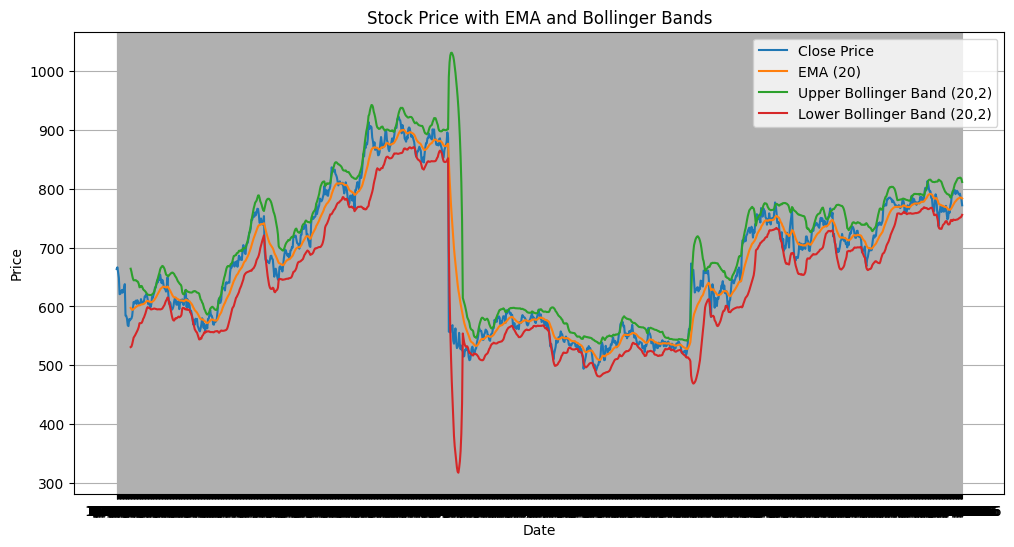

In [7]:
def calculate_ema(data, window):
  """
  This function calculates the Exponential Moving Average (EMA) for a given window.
  """
  return data.ewm(span=window, min_periods=window).mean()

def calculate_bollinger_bands(data, window, std):
  """
  This function calculates the Bollinger Bands (BB) and returns the upper and lower bands.
  """
  ema = calculate_ema(data, window)  # Calculate EMA but don't assign it to a variable
  upper_band = ema + std * data.rolling(window=window).std()
  lower_band = ema - std * data.rolling(window=window).std()
  return upper_band, lower_band

# Set window length and standard deviation
window_length = 20
std_dev = 2

# Ensure 'Close' column is numeric before conversion
if pd.api.types.is_numeric_dtype(data['Close']):
  data['Close'] = data['Close'].astype(float)  # Convert to float
else:
  print("Error: 'Close' column contains non-numeric data. EMA calculation requires numeric values.")
  exit()

# Calculate indicators (handle potential errors)
try:
  ema = calculate_ema(data['Close'], window_length)
  upper_band, lower_band = calculate_bollinger_bands(data['Close'], window_length, std_dev)
except KeyError:
  print("Error: 'Close' column not found in the data. Please check your data format.")
  exit()

# Plot closing price, EMA, Bollinger Bands
plt.figure(figsize=(12, 6))
plt.plot(data['Date'], data['Close'], label='Close Price')
plt.plot(data['Date'], ema, label=f'EMA ({window_length})')
plt.plot(data['Date'], upper_band, label=f'Upper Bollinger Band ({window_length},{std_dev})')
plt.plot(data['Date'], lower_band, label=f'Lower Bollinger Band ({window_length},{std_dev})')
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('Stock Price with EMA and Bollinger Bands')
plt.legend()
plt.grid(True)
plt.show()

In [8]:
X_train = []
y_train = []

for i in range (60,1149): #60 : timestep // 1149 : length of the data
    X_train.append(trainData[i-60:i,0]) 
    y_train.append(trainData[i,0])

X_train,y_train = np.array(X_train),np.array(y_train)

In [9]:
X_train = np.reshape(X_train,(X_train.shape[0],X_train.shape[1],1)) #adding the batch_size axis
X_train.shape

(1089, 60, 1)

In [10]:
model = Sequential()

model.add(LSTM(units=100, return_sequences = True, input_shape =(X_train.shape[1],1)))
model.add(Dropout(0.2))

model.add(LSTM(units=100, return_sequences = True))
model.add(Dropout(0.2))

model.add(LSTM(units=100, return_sequences = True))
model.add(Dropout(0.2))

model.add(LSTM(units=100, return_sequences = False))
model.add(Dropout(0.2))

model.add(Dense(units =1))
model.compile(optimizer='adam',loss="mean_squared_error")

c:\Users\Ashis\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [11]:
hist = model.fit(X_train, y_train, epochs = 20, batch_size = 32, verbose=2)

Epoch 1/20
35/35 - 8s - 220ms/step - loss: 0.0374
Epoch 2/20
35/35 - 3s - 82ms/step - loss: 0.0117
Epoch 3/20
35/35 - 3s - 85ms/step - loss: 0.0105
Epoch 4/20
35/35 - 3s - 86ms/step - loss: 0.0088
Epoch 5/20
35/35 - 3s - 82ms/step - loss: 0.0086
Epoch 6/20
35/35 - 3s - 86ms/step - loss: 0.0069
Epoch 7/20
35/35 - 3s - 100ms/step - loss: 0.0085
Epoch 8/20
35/35 - 4s - 102ms/step - loss: 0.0065
Epoch 9/20
35/35 - 4s - 102ms/step - loss: 0.0062
Epoch 10/20
35/35 - 3s - 97ms/step - loss: 0.0067
Epoch 11/20
35/35 - 4s - 101ms/step - loss: 0.0059
Epoch 12/20
35/35 - 4s - 103ms/step - loss: 0.0055
Epoch 13/20
35/35 - 4s - 102ms/step - loss: 0.0055
Epoch 14/20
35/35 - 3s - 97ms/step - loss: 0.0057
Epoch 15/20
35/35 - 4s - 107ms/step - loss: 0.0051
Epoch 16/20
35/35 - 4s - 110ms/step - loss: 0.0048
Epoch 17/20
35/35 - 4s - 104ms/step - loss: 0.0057
Epoch 18/20
35/35 - 4s - 104ms/step - loss: 0.0057
Epoch 19/20
35/35 - 3s - 96ms/step - loss: 0.0043
Epoch 20/20
35/35 - 3s - 96ms/step - loss: 0.004

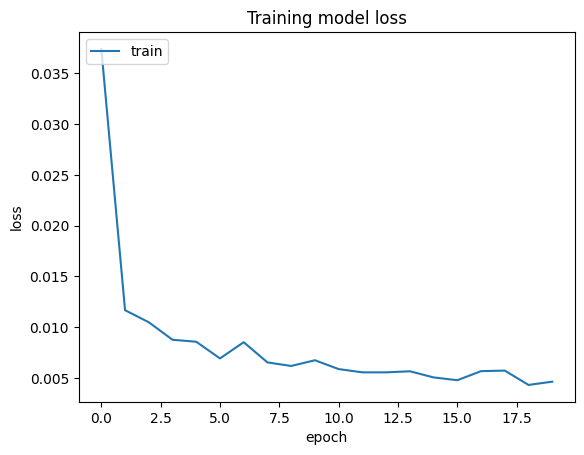

In [12]:
plt.plot(hist.history['loss'])
plt.title('Training model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper left')
plt.show()

In [ ]:
testData = pd.read_csv('Google_test_data.csv')
testData["Close"]=pd.to_numeric(testData.Close,errors='coerce')
testData = testData.dropna()
testData = testData.iloc[:,4:5]
y_test = testData.iloc[60:,0:].values 
#input array for the model
inputClosing = testData.iloc[:,0:].values 
inputClosing_scaled = sc.transform(inputClosing)
inputClosing_scaled.shape
X_test = []
length = len(testData)
timestep = 60
for i in range(timestep,length):  
    X_test.append(inputClosing_scaled[i-timestep:i,0])
X_test = np.array(X_test)
X_test = np.reshape(X_test,(X_test.shape[F0],X_test.shape[1],1))
X_test.shape

(192, 60, 1)

In [14]:
y_pred = model.predict(X_test)
y_pred

6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step


array([[1.3499087],
       [1.3524656],
       [1.3647798],
       [1.3834448],
       [1.398324 ],
       [1.3980013],
       [1.3833362],
       [1.3634973],
       [1.3511757],
       [1.3485103],
       [1.341925 ],
       [1.330165 ],
       [1.3194028],
       [1.309337 ],
       [1.3071567],
       [1.312105 ],
       [1.3319014],
       [1.3629575],
       [1.3981856],
       [1.4328433],
       [1.4463116],
       [1.4421216],
       [1.4195464],
       [1.387844 ],
       [1.3598378],
       [1.344616 ],
       [1.3419398],
       [1.3423775],
       [1.3348575],
       [1.3226877],
       [1.3089851],
       [1.2934693],
       [1.2706709],
       [1.2427729],
       [1.2313783],
       [1.2417893],
       [1.2658521],
       [1.2930037],
       [1.3183541],
       [1.3307124],
       [1.343325 ],
       [1.359222 ],
       [1.3782122],
       [1.396204 ],
       [1.408595 ],
       [1.410571 ],
       [1.4003243],
       [1.3912396],
       [1.3894401],
       [1.396736 ],


In [15]:
predicted_price = sc.inverse_transform(y_pred)

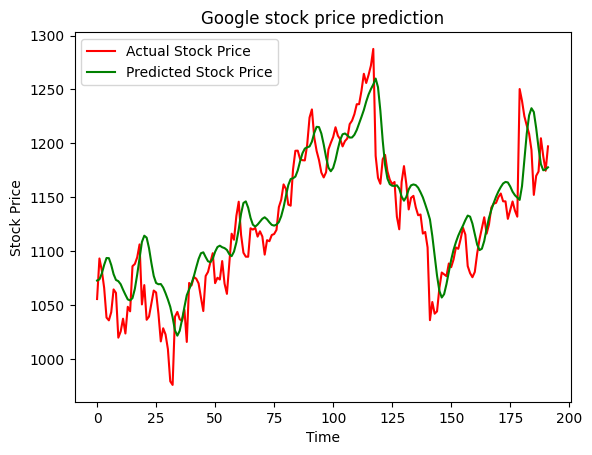

In [16]:
plt.plot(y_test, color = 'red', label = 'Actual Stock Price')
plt.plot(predicted_price, color = 'green', label = 'Predicted Stock Price')
plt.title('Google stock price prediction')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

In [24]:
from sklearn.metrics import mean_absolute_error

mae = mean_absolute_error(y_test/1000, y_pred[:, 0])
print(f"Mean Absolute Error (MAE): {mae:.2f}")

Mean Absolute Error (MAE): 0.37
